In [15]:
# %% [markdown]
# ## 0) Ortak ayarlar + veri yükleme
from pathlib import Path
import pandas as pd, numpy as np, vectorbt as vbt

DATA_DIR = Path(r"C:\DukascopyData")           # Parquet klasörü
FILE      = DATA_DIR / "EURUSD_1min.parquet"

FREQ_STR  = "4h"                               # yıllıklaştırma frekansı
FAST_W    = np.arange(10, 41, 5)               # 10 – 40
SLOW_W    = np.arange(60, 181, 20)             # 60 – 180
MC_SIM    = 1_000                              # Monte-Carlo adedi

print("► Veri okunuyor…")
price_1m  = pd.read_parquet(FILE)["EURUSD"]
price_4h  = price_1m.resample("4H").last().dropna()

split_date = price_4h.index[0] + pd.DateOffset(years=9)
price_in, price_out = price_4h.loc[:split_date], price_4h.loc[split_date:]


► Veri okunuyor…


C:\Users\PC\AppData\Local\Temp\ipykernel_2740\2393288178.py:16: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [16]:
# %% [markdown]
# ## 1) Parametre optimizasyonu (in-sample 9 yıl)
import pickle, os
from tqdm.auto import tqdm

CACHE = DATA_DIR / "eurusd_ma_grid.pkl"

if CACHE.exists():
    print("► Önceki sonuç bulundu – yükleniyor…")
    best_fast, best_slow, best_sharpe = pickle.load(open(CACHE, "rb"))
else:
    print("► Grid taraması başlıyor…")
    best_sharpe, best_fast, best_slow = -np.inf, None, None
    bar = tqdm(total=len(FAST_W)*len(SLOW_W), desc="Grid")
    for f in FAST_W:
        for s in SLOW_W:
            fast = vbt.MA.run(price_in, window=f)
            slow = vbt.MA.run(price_in, window=s)
            pf   = vbt.Portfolio.from_signals(
                price_in,
                fast.ma_crossed_above(slow),
                fast.ma_crossed_below(slow)
            )
            sharpe = pf.sharpe_ratio(freq=FREQ_STR)
            if sharpe > best_sharpe:
                best_sharpe, best_fast, best_slow = sharpe, f, s
            bar.set_postfix({"f": f, "s": s, "Sharpe": f"{sharpe:.2f}"})
            bar.update(1)
    bar.close()
    pickle.dump((best_fast, best_slow, best_sharpe), open(CACHE, "wb"))

print(f"\n✔ En iyi Sharpe {best_sharpe:.2f}  "
      f"(fast={best_fast}, slow={best_slow})")


► Grid taraması başlıyor…


Grid:   0%|          | 0/49 [00:00<?, ?it/s]


✔ En iyi Sharpe -0.06  (fast=15, slow=60)


In [19]:
# %% [markdown]
# ## 2) Out-of-sample (1y) + grafik  —  nbformat yoksa bile çalışır
import pandas as pd, plotly.io as pio
pio.renderers.default = "browser"      # ← ister notebook, ister browser seç

fast_o = vbt.MA.run(price_out, window=best_fast)
slow_o = vbt.MA.run(price_out, window=best_slow)

pf_o = vbt.Portfolio.from_signals(
    price_out,
    fast_o.ma_crossed_above(slow_o),
    fast_o.ma_crossed_below(slow_o)
)

oos = pd.Series({
    "total_return" : pf_o.total_return(),
    "sharpe"       : pf_o.sharpe_ratio(freq=FREQ_STR),
    "max_drawdown" : pf_o.max_drawdown()
})
print("\n--- OUT-OF-SAMPLE ---")
print(oos)

# Grafik: tarayıcıda açar
pf_o.plot().show()



--- OUT-OF-SAMPLE ---
total_return    0.084342
sharpe          1.279349
max_drawdown   -0.035873
dtype: float64


C:\Users\PC\AppData\Local\Temp\ipykernel_2740\363788877.py:48: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



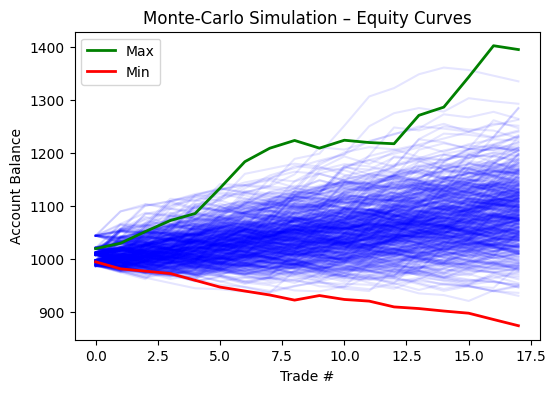

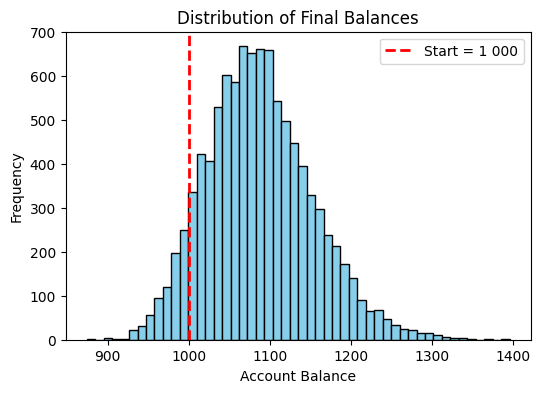

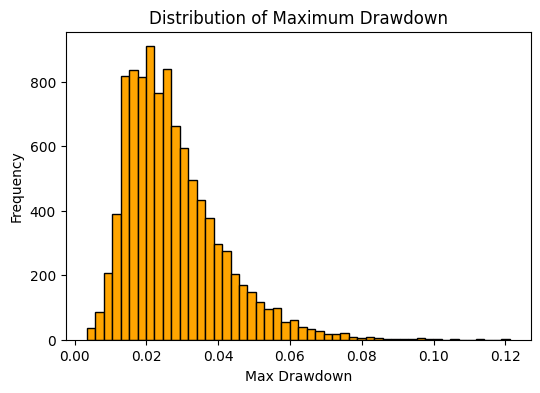


--- Monte-Carlo Summary ---
Starting Balance              : 1,000.00
Mean Final Balance            : 1,087.03
Std-Dev Final Balance         : 65.47
Min Final Balance             : 874.30
Max Final Balance             : 1,395.33
% > Mean Balance              : 47.46 %
Max DD (worst)                : 12.12%
Mean Max DD                   : 2.75%
99th-pct DD                   : 6.97%
Sharpe (annualised)           : 4.38
Sortino (annualised)          : 14.94


In [25]:
# %% [markdown]
# ## 3) Monte-Carlo – grafik + istatistikler (sürüm bağımsız)

import numpy as np, matplotlib.pyplot as plt, pandas as pd, random

# ---------------- Yardımcı fonksiyonlar -----------------------------------
def drawdown_path(balance):
    peak = np.maximum.accumulate(balance)
    return (peak - balance) / peak

def sharpe_ratio(monthly, rf):
    excess = monthly - rf/12
    return np.mean(excess) / np.std(excess, ddof=1) * np.sqrt(12)

def sortino_ratio(monthly, rf):
    excess = monthly - rf/12
    downside = excess[excess < 0]
    if downside.size == 0: return np.nan
    return np.mean(excess) / np.std(downside, ddof=1) * np.sqrt(12)

# ------------- Parametreler ----------------------------------------------
start_balance  = 1_000
n_sim          = 10_000
risk_free_rate = 0.05
random.seed(42); np.random.seed(42)

# ------------- Trade getirilerini çıkar -----------------------------------
records = pf_o.positions.records
try:
    trade_ret = records.readable["return"].values + 1   # vbt ≥0.25
except AttributeError:
    trade_ret = records["return"] + 1                   # vbt <0.25
if trade_ret.size == 0:
    raise ValueError("Strateji hiç pozisyon üretmemiş; MC yapılamaz.")

# ---------------- Monte-Carlo ---------------------------------------------
final_bal, max_dd, monthly_all, curves = [], [], [], []
for _ in range(n_sim):
    path = np.random.choice(trade_ret, size=trade_ret.size, replace=True)
    curve = start_balance * np.cumprod(path)
    curves.append(curve)

    final_bal.append(curve[-1])
    max_dd.append(drawdown_path(curve).max())

    # ay bazlı getiri (sanal zaman ekseni)
    idx = pd.date_range("2000", periods=curve.size, freq="D")
    m = pd.Series(path-1, index=idx).resample("M").apply(lambda x: (1+x).prod()-1)
    monthly_all.append(m.values)

monthly_flat = np.concatenate(monthly_all)

# 1) 500 equity-curve örneği ------------------------------------------------
plt.figure(figsize=(6,4))
for c in random.sample(curves, min(500, n_sim)):
    plt.plot(c, color="blue", alpha=0.1)
plt.plot(curves[np.argmax(final_bal)], color="green", lw=2, label="Max")
plt.plot(curves[np.argmin(final_bal)], color="red",   lw=2, label="Min")
plt.title("Monte-Carlo Simulation – Equity Curves")
plt.xlabel("Trade #"); plt.ylabel("Account Balance"); plt.legend(); plt.show()

# 2) Final balance histogram -----------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(final_bal, bins=50, color="skyblue", edgecolor="black")
plt.axvline(start_balance, color="red", ls="--", lw=2, label="Start = 1 000")
plt.title("Distribution of Final Balances")
plt.xlabel("Account Balance"); plt.ylabel("Frequency"); plt.legend(); plt.show()

# 3) Max-drawdown histogram -------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(max_dd, bins=50, color="orange", edgecolor="black")
plt.title("Distribution of Maximum Drawdown")
plt.xlabel("Max Drawdown"); plt.ylabel("Frequency"); plt.show()

# ---------------- İstatistikler -------------------------------------------
mean_bal   = np.mean(final_bal)
pct_above  = (np.array(final_bal) > mean_bal).mean()*100
stats = {
    "Starting Balance"           : f"{start_balance:,.2f}",
    "Mean Final Balance"         : f"{mean_bal:,.2f}",
    "Std-Dev Final Balance"      : f"{np.std(final_bal):,.2f}",
    "Min Final Balance"          : f"{np.min(final_bal):,.2f}",
    "Max Final Balance"          : f"{np.max(final_bal):,.2f}",
    "% > Mean Balance"           : f"{pct_above:.2f} %",
    "Max DD (worst)"             : f"{max(max_dd):.2%}",
    "Mean Max DD"                : f"{np.mean(max_dd):.2%}",
    "99th-pct DD"                : f"{np.percentile(max_dd,99):.2%}",
    "Sharpe (annualised)"        : f"{sharpe_ratio(monthly_flat,risk_free_rate):.2f}",
    "Sortino (annualised)"       : f"{sortino_ratio(monthly_flat,risk_free_rate):.2f}",
}
print("\n--- Monte-Carlo Summary ---")
for k,v in stats.items(): print(f"{k:<30}: {v}")
